In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scvelo as scv
import scrublet as scr
import scanpy.external as sce
import numpy as np
import pandas as pd
import scanpy as sc
import cellrank as cr
import phate
import bbknn
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix



scv.logging.print_version()
scv.settings.verbosity = 3  
scv.settings.set_figure_params('scvelo') 

Running scvelo 0.2.4 (python 3.9.7) on 2023-08-09 08:06.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [3]:
##load non-nascent RNA, used for data normalization
adata = sc.read("EU_E85_old_matrix.csv").T

In [4]:
#pre-processing
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.var['mt'] = adata.var_names.str.startswith('-mt-')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
sc.tl.leiden(adata, resolution = 3)
sc.tl.umap(adata)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
#load UMAP coordinates and cell-type annotation
anno = pd.read_csv("E85_UMAP_nascent.csv", dtype = "category", encoding ="latin")

adata.obs['celltype'] = anno['cell_type'].values
adata.obsm['X_umap'][:,0] =anno["UMAP_1"].values
adata.obsm['X_umap'][:,1] =anno["UMAP_2"].values

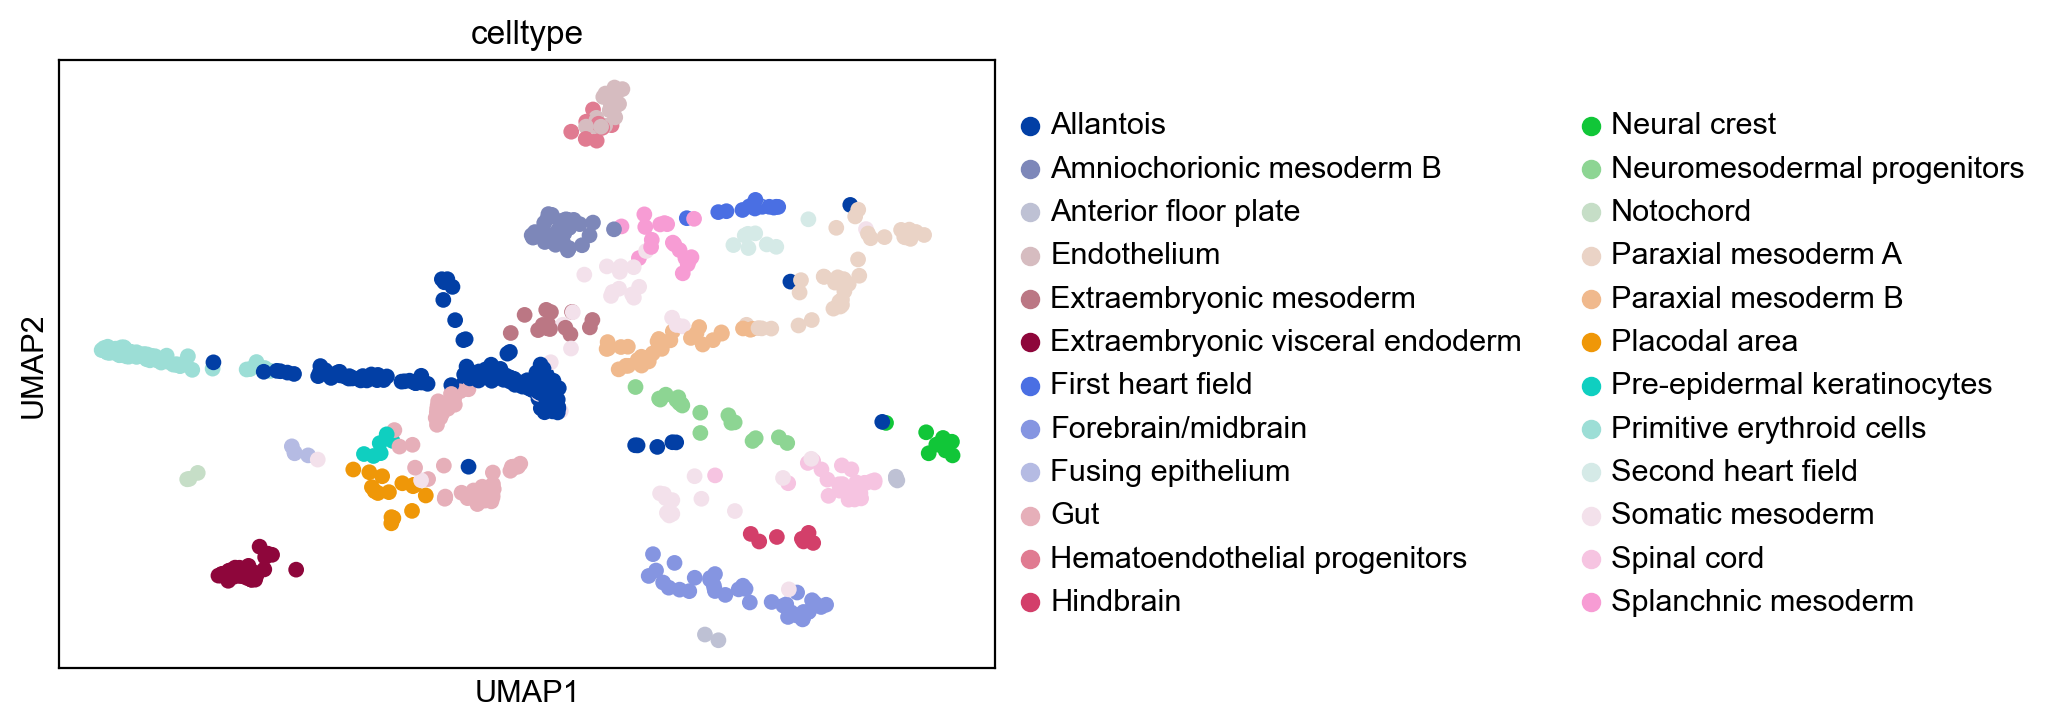

In [8]:
sc.pl.umap(adata,color="celltype")

In [9]:
# load the nascent and non-nascent matrices into the unspliced and spliced layers
adatas = sc.read("E85_old_curated.csv", cache=True).T 
adatal = sc.read("E85_new_curated.csv").T   
adata.layers["spliced"] = adatas.X
adata.layers["unspliced"] = adatal.X

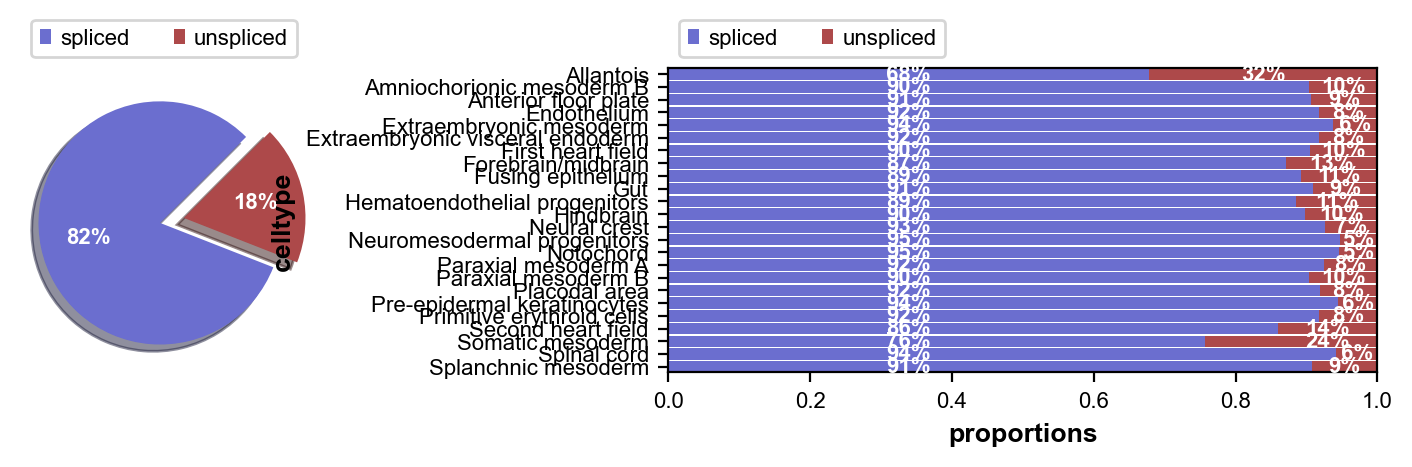

In [10]:
#plot proportions
scv.pl.proportions(adata,groupby='celltype')

In [11]:
#velocity computation
scv.pp.normalize_per_cell(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/936 [00:00<?, ?cells/s]

/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 1/6 cores)


  0%|          | 0/282 [00:00<?, ?gene/s]

/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:01:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/936 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [12]:
#colour scheme
adata.uns["celltype_colors"] = ['#997D87',
'#B79762',
'#3B5DFF',
'#004D43',
'#7A4900',
'#1B4400',
'#4FC601',
'#1CE6FF',
'#FF2F80',
'#8FB0FF',
'#4A3B53',
'#FF4A46',
'#0000A6',
'#008941',
'#61615A',
'#FF34FF',
'#63FFAC',
'#FFDBE5',
'#5A0007',
'#6A3A4C',
'#809693',
'#006FA6',
'#FFFF00',
'#A30059']

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


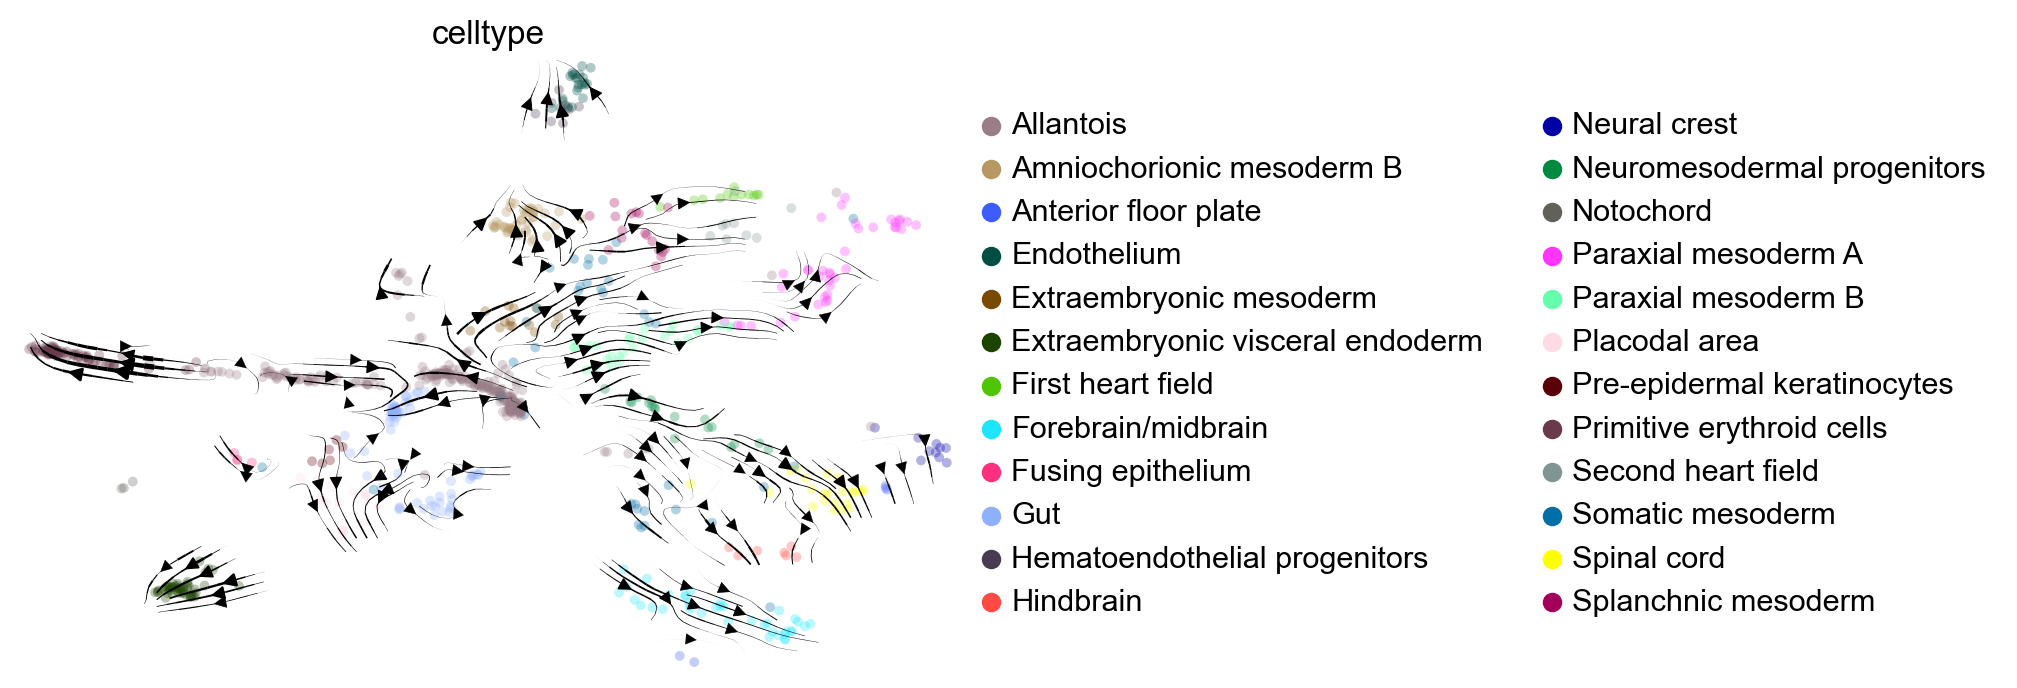

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=["celltype"],legend_loc='right_margin', size=50,density=3)

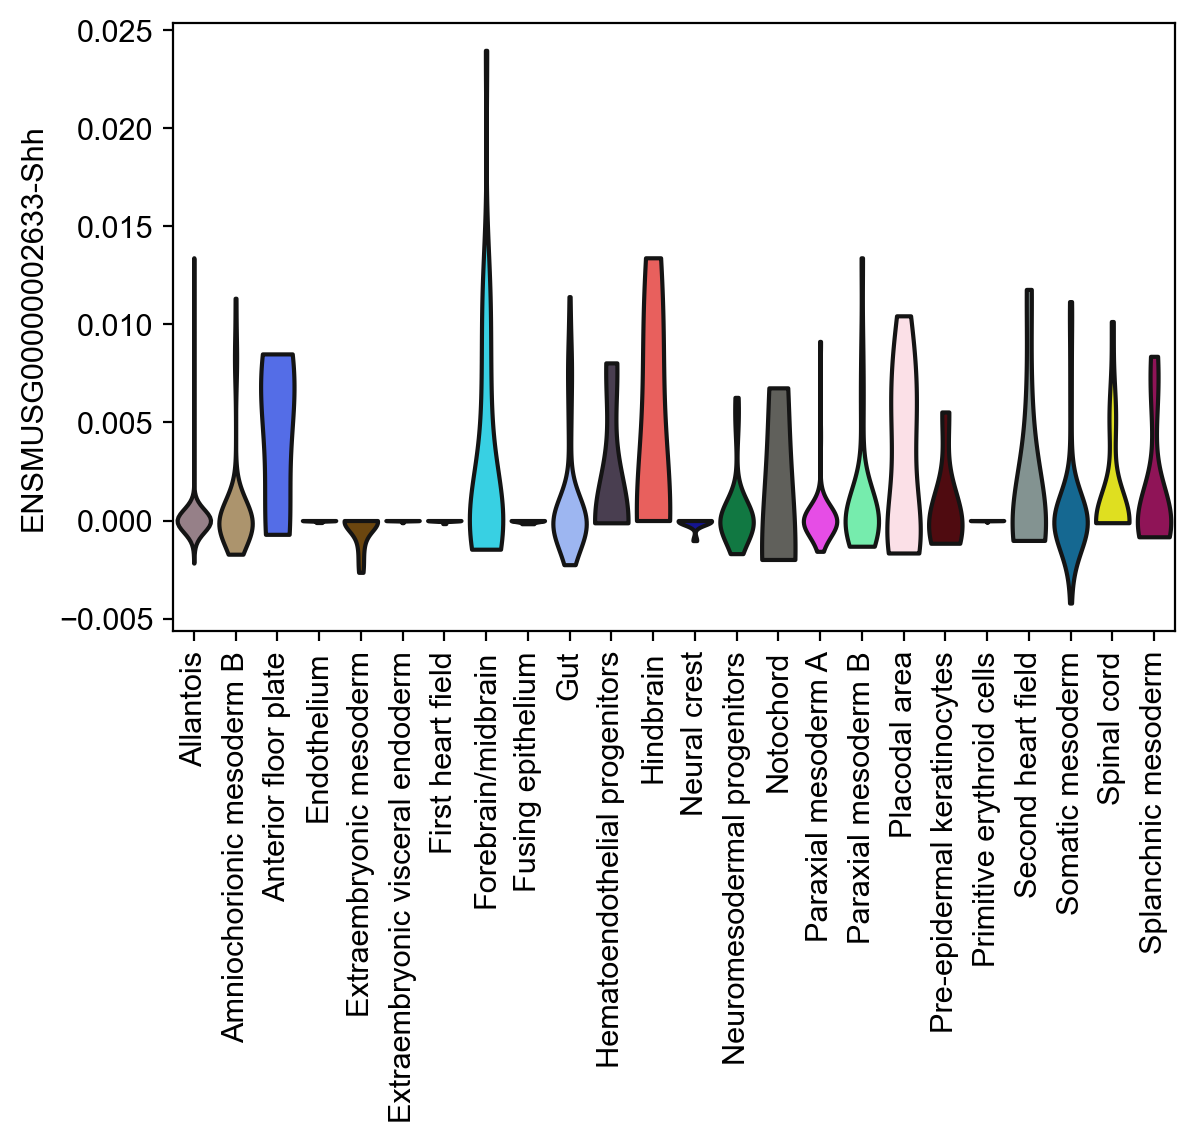

In [14]:
sc.pl.violin(adata,keys=["ENSMUSG00000002633-Shh"], groupby="celltype", layer = "velocity", use_raw=False, size = 0, rotation=90, n_cols =1)

In [15]:
#Subset to NMP trajectory
adata_NMP  = adata[(adata.obs["celltype"]=="Neuromesodermal progenitors") | (adata.obs["celltype"]=="Paraxial mesoderm B") |(adata.obs["celltype"]=="Paraxial mesoderm A") | 
                  (adata.obs["celltype"]=="Spinal cord") ,] 

In [16]:
sc.pp.neighbors(adata_NMP)
scv.tl.velocity(adata_NMP, mode='stochastic')
scv.tl.velocity_graph(adata_NMP)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/109 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


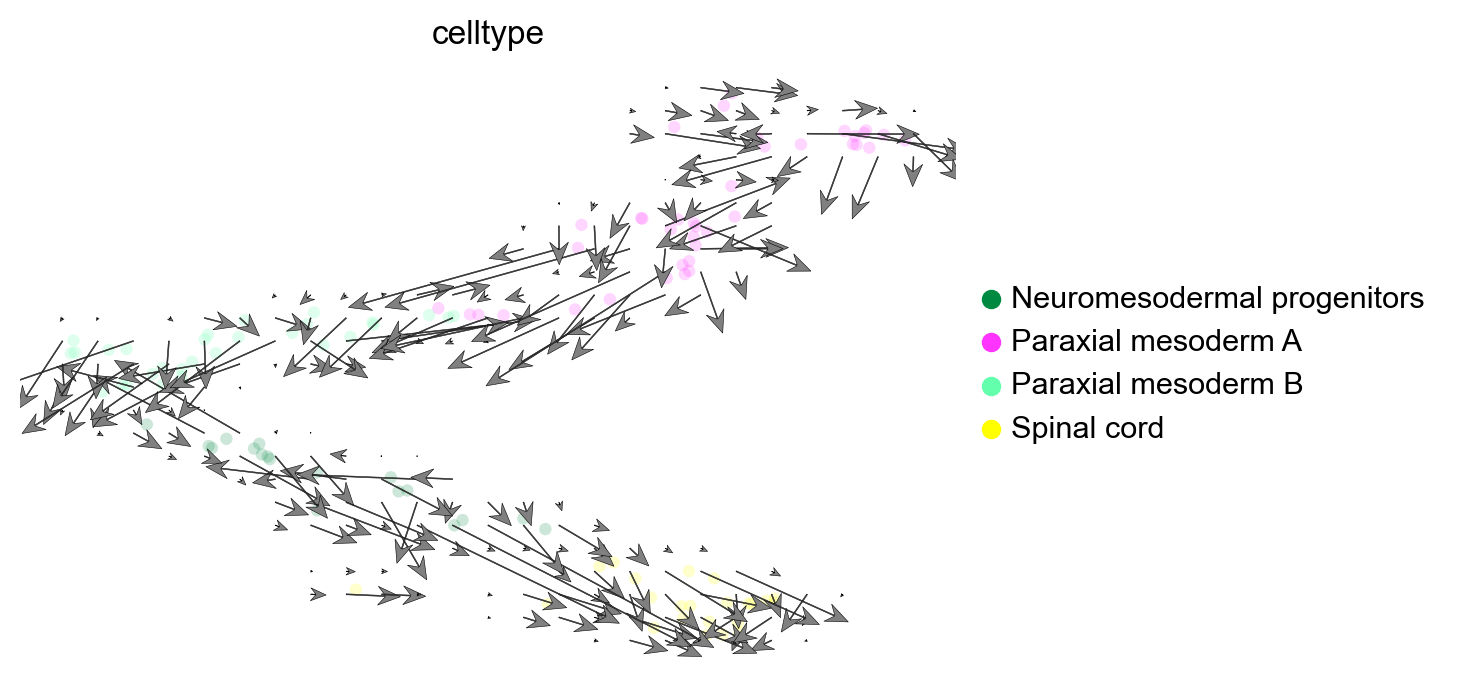

In [17]:
scv.pl.velocity_embedding_grid(adata_NMP, basis='umap', color=["celltype"], legend_loc='right_margin', size=80,density=0.5,arrow_length=5,arrow_size=4)

In [18]:
scv.tl.latent_time(adata_NMP,root_key="Neuromesodermal progenitors")
cr.tl.terminal_states(adata_NMP, cluster_key="celltype", weight_connectivities=0.5,n_states=2, n_cells=20)
cr.tl.initial_states(adata_NMP, cluster_key="celltype",    n_cells=30,
    softmax_scale=4,
    n_states=1)
cr.tl.lineages(adata_NMP)


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_41375/2014516489.py:2: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata_NMP, cluster_key="celltype", weight_connectivities=0.5,n_states=2, n_cells=20)
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/109 [00:00<?, ?cell/s]

  0%|          | 0/109 [00:00<?, ?cell/s]

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_41375/2014516489.py:3: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata_NMP, cluster_key="celltype",    n_cells=30,
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/109 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_41375/2014516489.py:6: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata_NMP)


  0%|          | 0/2 [00:00<?, ?/s]

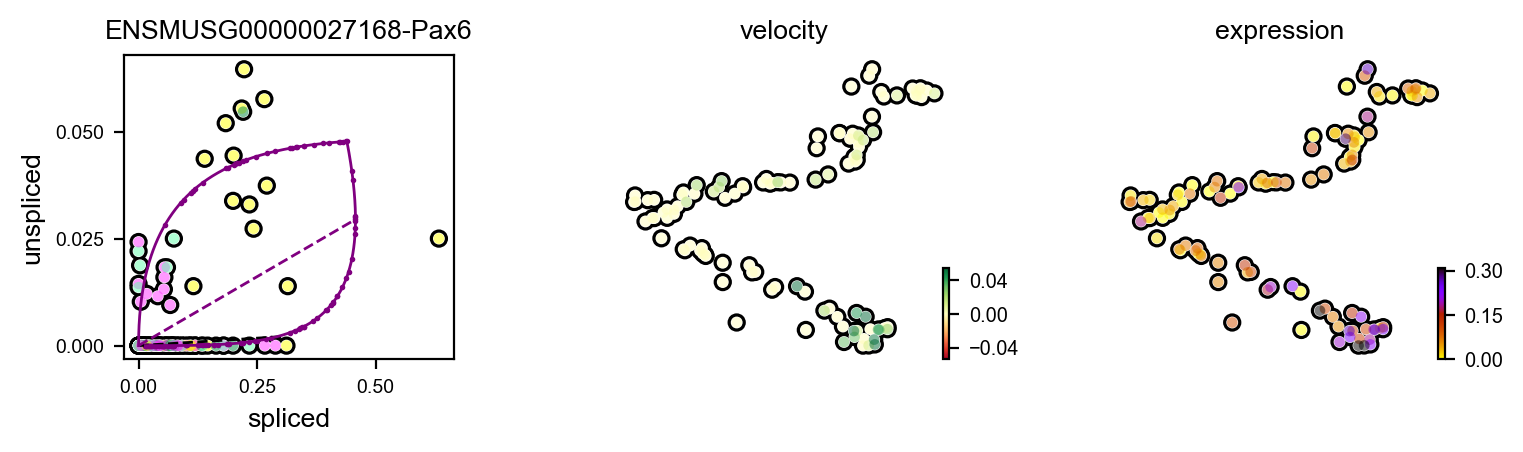

In [19]:
scv.pl.velocity(adata_NMP, ['ENSMUSG00000027168-Pax6'], color = ["celltype"], ncols=2, add_outline=True,size=60)

In [20]:
#subset to blood trajectory
adata_blood  = adata[(adata.obs["celltype"]=="Primitive erythroid cells") ,] 

In [21]:
scv.pl.velocity(adata_blood, ["ENSMUSG00000085700-Hbb-bh0","ENSMUSG00000052217-Hbb-bh1","ENSMUSG00000052187-Hbb-y"], color = ["celltype"], ncols=3, add_outline=True, dpi=800, size=60)

/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:164: ImplicitModificationWarning: Trying to modify attribute `.layers` of view, initializing view as actual.
  y[-1] = stop


In [22]:
#subset to endothelial trajectory
adata_e = adata[(adata.obs["celltype"]=="Hematoendothelial progenitors") |(adata.obs["celltype"]=="Endothelium") ,] 

In [ ]:
sc.pp.neighbors(adata_e)
scv.tl.velocity(adata_e, mode='stochastic')
scv.tl.velocity_graph(adata_e)
cr.tl.terminal_states(adata_e, cluster_key="celltype")
cr.tl.initial_states(adata_e, cluster_key="celltype",    n_cells=10,
    softmax_scale=4,
    n_states=1)
cr.tl.lineages(adata_e)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/33 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_41375/1875135907.py:4: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata_e, cluster_key="celltype")
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_mat

  0%|          | 0/33 [00:00<?, ?cell/s]

  0%|          | 0/33 [00:00<?, ?cell/s]

In [ ]:
#compute lineage drivers
cr.tl.lineage_drivers(adata_e,lineage ="Endothelium")